In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import missingno

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv("/content/drive/My Drive/Data/Sales Forecasting/data.csv",encoding='unicode_escape')
df.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom


# CUSTOMER SEGMENTATION CONTEXT


RFM stands for Recency - Frequency - Monetary Value. Theoretically we will have 
segments like below:

Low Value: Customers who are less active than others, not very frequent buyer/
visitor and generates very low - zero - maybe negative revenue.

Mid Value: In the middle of everything. Often using our platform (but not as much as our High Values), fairly frequent and generates moderate revenue.

High Value: The group we don’t want to lose. High Revenue, Frequency and low Inactivity.


**Recency**

To calculate recency, we need to find out most recent purchase date of each customer and see how many days they are inactive for. After having no. of inactive days for each customer, we will apply K-means* clustering to assign customers a recency score.


In [4]:
print("Columns:-",df.columns)
print("Unique Countries",df['Country'].unique())

Columns:- Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')
Unique Countries ['United Kingdom' 'France' 'Australia' 'Netherlands' 'Germany' 'Norway'
 'EIRE' 'Switzerland' 'Spain' 'Poland' 'Portugal' 'Italy' 'Belgium'
 'Lithuania' 'Japan' 'Iceland' 'Channel Islands' 'Denmark' 'Cyprus'
 'Sweden' 'Austria' 'Israel' 'Finland' 'Bahrain' 'Greece' 'Hong Kong'
 'Singapore' 'Lebanon' 'United Arab Emirates' 'Saudi Arabia'
 'Czech Republic' 'Canada' 'Unspecified' 'Brazil' 'USA'
 'European Community' 'Malta' 'RSA']


<Axes: >

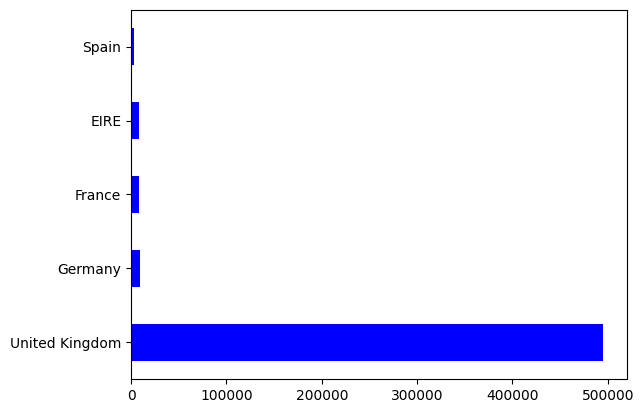

In [5]:
df['Country'].value_counts().head().plot(kind='barh',color='blue')

In [6]:
#AS YOU CAN SEE THE COUNTRY UK HAVE MORE DATA POINTS COMPARED TO ITS PEERS SO
#TAKE UK DATA ONLY
data_uk = df.query("Country=='United Kingdom'").reset_index(drop=True)
data_uk.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


***MISSING VALUES PLOT***

<Axes: >

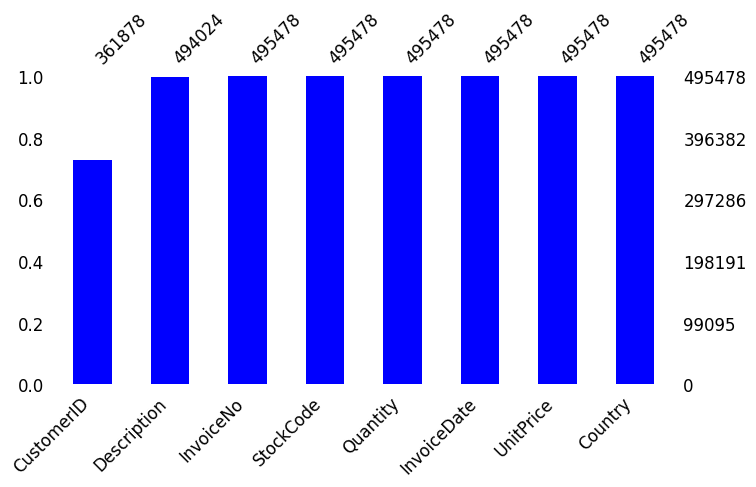

In [7]:
missingno.bar(data_uk, figsize=(8,4), fontsize=12,sort='ascending',color='blue')

In [8]:
#convert the string date field to datetime
data_uk['InvoiceDate'] = pd.to_datetime(data_uk['InvoiceDate'])

In [49]:
tx_user = pd.DataFrame(data_uk['CustomerID'].unique(),columns=['CustomerID'])
tx_user.head(3)

,CustomerID
0,17850.0
1,13047.0
2,13748.0


In [50]:
tx_user.shape

(3951, 1)

In [51]:
#get the max purchase date for each customer and create a dataframe with it
tx_max_purchase = data_uk.groupby('CustomerID').InvoiceDate.max().reset_index()
tx_max_purchase.columns = ['CustomerID','MaxPurchaseDate']
tx_max_purchase

,CustomerID,MaxPurchaseDate
0,12346.0,2011-01-18 10:17:00
1,12747.0,2011-12-07 14:34:00
2,12748.0,2011-12-09 12:20:00
3,12749.0,2011-12-06 09:56:00
4,12820.0,2011-12-06 15:12:00
...,...,...
3945,18280.0,2011-03-07 09:52:00
3946,18281.0,2011-06-12 10:53:00
3947,18282.0,2011-12-02 11:43:00
3948,18283.0,2011-12-06 12:02:00


In [52]:
tx_max_purchase['MaxPurchaseDate'].max()

Timestamp('2011-12-09 12:49:00')

In [53]:

#we take our observation point as the max invoice date in our dataset
tx_max_purchase['Recency'] = (tx_max_purchase['MaxPurchaseDate'].max() - tx_max_purchase['MaxPurchaseDate']).dt.days

tx_max_purchase

,CustomerID,MaxPurchaseDate,Recency
0,12346.0,2011-01-18 10:17:00,325
1,12747.0,2011-12-07 14:34:00,1
2,12748.0,2011-12-09 12:20:00,0
3,12749.0,2011-12-06 09:56:00,3
4,12820.0,2011-12-06 15:12:00,2
...,...,...,...
3945,18280.0,2011-03-07 09:52:00,277
3946,18281.0,2011-06-12 10:53:00,180
3947,18282.0,2011-12-02 11:43:00,7
3948,18283.0,2011-12-06 12:02:00,3


In [54]:
#merge this dataframe to our new user dataframe
tx_user = pd.merge(tx_user, tx_max_purchase[['CustomerID','Recency']], on='CustomerID')
tx_user.head()

,CustomerID,Recency
0,17850.0,301
1,13047.0,31
2,13748.0,95
3,15100.0,329
4,15291.0,25


In [55]:
tx_user.describe()

,CustomerID,Recency
count,3950.000000,3950.000000
mean,15562.029367,90.778481
std,1576.848325,100.230349
min,12346.000000,0.000000
25%,14208.250000,16.000000
50%,15571.500000,49.000000
75%,16913.750000,142.000000
max,18287.000000,373.000000


<Axes: xlabel='Recency', ylabel='Count'>

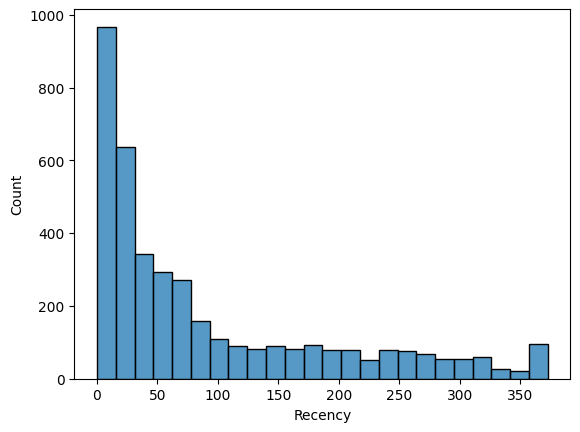

In [56]:
sns.histplot(data=tx_user, x="Recency")

**JUST DETERMINING HERE HOW MANY CLUSTERS CAN WE TAKE--> ELBOW CURVE **

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-83-fcef6f1693e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tx_recency["clusters"] = kmeans.labels_
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-83-fcef6f1693e7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

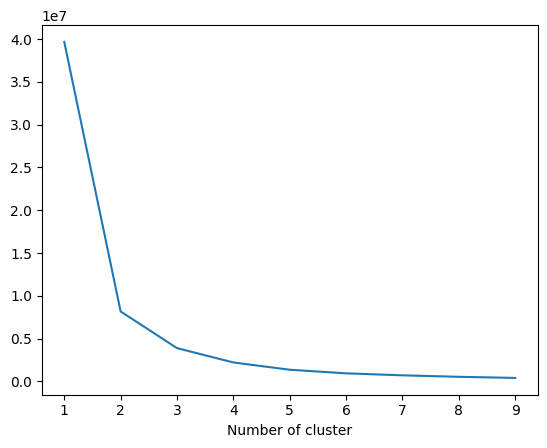

In [83]:
from sklearn.cluster import KMeans

sse={}
tx_recency = tx_user[['Recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_recency)
    tx_recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
    # print("*********************************",kmeans.inertia_)
    # print("--------------------------------",kmeans.labels_)
    
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [84]:
#sse

# RECENCY

In [58]:
#build 4 clusters for recency and add it to dataframe
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Recency']])
tx_user['RecencyCluster'] = kmeans.predict(tx_user[['Recency']])

tx_user

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,CustomerID,Recency,RecencyCluster
0,17850.0,301,0
1,13047.0,31,2
2,13748.0,95,1
3,15100.0,329,0
4,15291.0,25,2
...,...,...,...
3945,15471.0,1,2
3946,13436.0,1,2
3947,15520.0,1,2
3948,13298.0,0,2


In [65]:
#DEBUGGING OF THE BELOW BOX I.E HOW THEY ORDER CLUSTER
temp = tx_user.copy()

#TAKING MEAN ACCORDING TO CLUSTER
df_new = temp.groupby('RecencyCluster')['Recency'].mean().reset_index()

#SORTING THE DATA ACCORDINT TO RECENCY MEAN VALUES AND WE ARE SORTING THEM IN DESCENDING ORDER SO THAT WE CAN TAKE MINIMUM MEAN VALUS
#WHICH REPRESENT THE MOST RECENT CUSTOMER PURCHASE 
df_new = df_new.sort_values(by='Recency',ascending=False).reset_index(drop=True)

#YOU CAN SEE HERE WE ARE CREATING NEW COLUMN AND ASSIGNING THE INDEX VALUE TO THEM
df_new['index'] = df_new.index

#MERGING BACK TO OUT MAIN DATA ON "RecencyCluster" . WHAT WILL HAPPEN HERE IS THAT PREVIOUSELY IF THE CLUSTER WAS 3 NOW 
#ACCORDING TO OUR INDEX COLUMN IT WILL BE 1 OR 2 OR ANY OTHER
df_final = pd.merge(temp,df_new[['RecencyCluster','index']], on='RecencyCluster')

#DROPPING THE INITIAL "RecencyCluster" COLUMN
df_final = df_final.drop(['RecencyCluster'],axis=1)

#RENAMING THE "index" COLUMN AS CLUSTER COLUMN 
df_final = df_final.rename(columns={"index":'RecencyCluster'})
df_final


,CustomerID,Recency,RecencyCluster
0,17850.0,301,0
1,15100.0,329,0
2,18074.0,373,0
3,16250.0,260,0
4,13747.0,373,0
...,...,...,...
3945,15942.0,133,1
3946,14143.0,133,1
3947,16147.0,133,1
3948,15149.0,133,1


In [64]:
df_new

,RecencyCluster,Recency,index
0,0,304.393305,0
1,3,184.625000,1
2,1,77.679245,2
3,2,17.488205,3


In [66]:
#function for ordering cluster numbers
def order_cluster(cluster_field_name, target_field_name,df,ascending):

    #new_cluster_field_name = 'new_' + cluster_field_name

    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()

    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)

    df_new['index'] = df_new.index

    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)

    df_final = df_final.drop([cluster_field_name],axis=1)

    df_final = df_final.rename(columns={"index":cluster_field_name})

    return df_final


tx_user = order_cluster('RecencyCluster', 'Recency',tx_user,False)


In [68]:
tx_user

,CustomerID,Recency,RecencyCluster
0,17850.0,301,0
1,15100.0,329,0
2,18074.0,373,0
3,16250.0,260,0
4,13747.0,373,0
...,...,...,...
3945,15942.0,133,1
3946,14143.0,133,1
3947,16147.0,133,1
3948,15149.0,133,1


# FREQUENCY

In [69]:
#get order counts for each user and create a dataframe with it
tx_frequency = data_uk.groupby('CustomerID').InvoiceDate.count().reset_index()
tx_frequency.columns = ['CustomerID','Frequency']

#add this data to our main dataframe
tx_user = pd.merge(tx_user, tx_frequency, on='CustomerID')
tx_user

,CustomerID,Recency,RecencyCluster,Frequency
0,17850.0,301,0,312
1,15100.0,329,0,6
2,18074.0,373,0,13
3,16250.0,260,0,24
4,13747.0,373,0,1
...,...,...,...,...
3945,15942.0,133,1,14
3946,14143.0,133,1,7
3947,16147.0,133,1,22
3948,15149.0,133,1,23


HERE WE ARE ORDERING THEM IN ASCENDING ORDER REPRESENTS THAT THE MORE THE FREQUENT CUSTOMER THE BETTER

tx_user = order_cluster('FrequencyCluster', 'Frequency',tx_user,True)

In [70]:
#k-means
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Frequency']])
tx_user['FrequencyCluster'] = kmeans.predict(tx_user[['Frequency']])

#order the frequency cluster

#HERE WE ARE ORDERING THEM IN ASCENDING ORDER REPRESENTS THAT THE MORE THE FREQUENT CUSTOMER THE BETTER
tx_user = order_cluster('FrequencyCluster', 'Frequency',tx_user,True)

#see details of each cluster

tx_user

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster
0,17850.0,301,0,312,1
1,15808.0,305,0,210,1
2,13047.0,31,3,196,1
3,14688.0,7,3,359,1
4,16029.0,38,3,274,1
...,...,...,...,...,...
3945,14056.0,0,3,1128,2
3946,14456.0,4,3,977,2
3947,12748.0,0,3,4642,3
3948,17841.0,1,3,7983,3


# MONETARY / REVENUE

In [72]:
#tx_user.groupby('FrequencyCluster')['Frequency'].describe()

In [73]:
#calculate revenue for each customer
data_uk['Revenue'] = data_uk['UnitPrice'] * data_uk['Quantity']
tx_revenue = data_uk.groupby('CustomerID').Revenue.sum().reset_index()

#merge it with our main dataframe
tx_user = pd.merge(tx_user, tx_revenue, on='CustomerID')
tx_user


,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue
0,17850.0,301,0,312,1,5288.63
1,15808.0,305,0,210,1,3724.77
2,13047.0,31,3,196,1,3079.10
3,14688.0,7,3,359,1,5107.38
4,16029.0,38,3,274,1,50992.61
...,...,...,...,...,...,...
3945,14056.0,0,3,1128,2,8124.40
3946,14456.0,4,3,977,2,3047.63
3947,12748.0,0,3,4642,3,29072.10
3948,17841.0,1,3,7983,3,40340.78


In [75]:
#apply clustering
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Revenue']])
tx_user['RevenueCluster'] = kmeans.predict(tx_user[['Revenue']])


#order the cluster numbers
#HERE WE ARE ORDERING THEM IN ASCENDING ORDER REPRESENTS THAT THE MORE THE REVENUE GENERATED BY CUSTOMER THE BETTER
tx_user = order_cluster('RevenueCluster', 'Revenue',tx_user,True)

tx_user

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster
0,17850.0,301,0,312,1,5288.63,1
1,14688.0,7,3,359,1,5107.38,1
2,13767.0,1,3,399,1,16945.71,1
3,15513.0,30,3,314,1,14520.08,1
4,14849.0,21,3,392,1,7904.28,1
...,...,...,...,...,...,...,...
3945,12748.0,0,3,4642,3,29072.10,2
3946,17841.0,1,3,7983,3,40340.78,2
3947,14096.0,3,3,5128,3,57120.91,2
3948,17450.0,7,3,351,1,187482.17,3


In [76]:
#show details of the dataframe
tx_user.groupby('RevenueCluster')['Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,3687.0,907.254414,921.910820,-4287.63,263.115,572.56,1258.220,4314.72
1,234.0,7760.699530,3637.173671,4330.67,5161.485,6549.38,9142.305,21535.90
2,27.0,43070.445185,15939.249588,25748.35,28865.490,36351.42,53489.790,88125.38
3,2.0,221960.330000,48759.481478,187482.17,204721.250,221960.33,239199.410,256438.49


In [77]:

tx_user['OverallScore'] = tx_user['RecencyCluster'] + tx_user['FrequencyCluster'] + tx_user['RevenueCluster']
print("Score values  ",tx_user['OverallScore'].unique())
tx_user

Score values   [2 5 4 1 3 6 0 7 8]


,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore
0,17850.0,301,0,312,1,5288.63,1,2
1,14688.0,7,3,359,1,5107.38,1,5
2,13767.0,1,3,399,1,16945.71,1,5
3,15513.0,30,3,314,1,14520.08,1,5
4,14849.0,21,3,392,1,7904.28,1,5
...,...,...,...,...,...,...,...,...
3945,12748.0,0,3,4642,3,29072.10,2,8
3946,17841.0,1,3,7983,3,40340.78,2,8
3947,14096.0,3,3,5128,3,57120.91,2,8
3948,17450.0,7,3,351,1,187482.17,3,7


In [78]:
tx_user.groupby('OverallScore')['Recency','Frequency','Revenue'].mean()


<ipython-input-78-b48e6257d241>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  tx_user.groupby('OverallScore')['Recency','Frequency','Revenue'].mean()


,Recency,Frequency,Revenue
OverallScore,,,
0,304.584388,21.995781,303.339705
1,185.362989,32.596085,498.087546
2,78.991304,46.963043,868.082991
3,20.689610,68.419590,1091.416414
4,14.892617,271.755034,3607.097114
5,9.662162,373.290541,9136.946014
6,7.740741,876.037037,22777.914815
7,1.857143,1272.714286,103954.025714
8,1.333333,5917.666667,42177.930000


# CUSTOMER BUCKETS

0 to 2: Low Value

3 to 4: Mid Value

5+: High Value

In [79]:
tx_user['Segment'] = 'Low-Value'
tx_user.loc[tx_user['OverallScore']>2,'Segment'] = 'Mid-Value' 
tx_user.loc[tx_user['OverallScore']>4,'Segment'] = 'High-Value' 
tx_user

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment
0,17850.0,301,0,312,1,5288.63,1,2,Low-Value
1,14688.0,7,3,359,1,5107.38,1,5,High-Value
2,13767.0,1,3,399,1,16945.71,1,5,High-Value
3,15513.0,30,3,314,1,14520.08,1,5,High-Value
4,14849.0,21,3,392,1,7904.28,1,5,High-Value
...,...,...,...,...,...,...,...,...,...
3945,12748.0,0,3,4642,3,29072.10,2,8,High-Value
3946,17841.0,1,3,7983,3,40340.78,2,8,High-Value
3947,14096.0,3,3,5128,3,57120.91,2,8,High-Value
3948,17450.0,7,3,351,1,187482.17,3,7,High-Value


# VISUALIZATION

DIVIDING THE DATA FOR BETTER VISUALIZATION



In [ ]:
#TAKING ONLY THOSE CUSTOMER WHOSE FREQUENCY IS LESS THAT 2000 and REVENUE < 50000 FOR BETTER VIEW
temp_data = tx_user.loc[(tx_user['Frequency']< 2000) & (tx_user['Revenue']< 50000)]

# MONETARY VS FREQUENCY

**HERE WE CAN DETERMINE IS THAT THE HIGHER THE FREQUENCY I.E CUSTOMER WHO IS MOST FREQUENT IS ABLE TO GENERATE MORE PROFITS/REVENUE**

<Axes: xlabel='Frequency', ylabel='Revenue'>

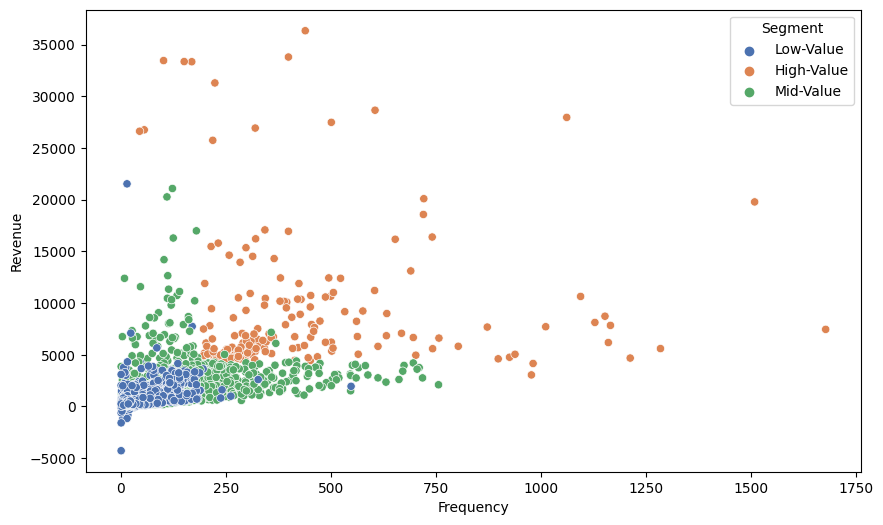

In [95]:
fig, ax = plt.subplots(figsize=(10,6))
sns.scatterplot(ax=ax, data=temp_data, x="Frequency", y="Revenue",hue='Segment',palette="deep")

# RECENCY VS FREQUENCY

**HERE WE CAN DETERMINE IS THAT THE MOST RECENT CUSTOMER IS THE MOST FREQUENT ONE**

<Axes: xlabel='Recency', ylabel='Frequency'>

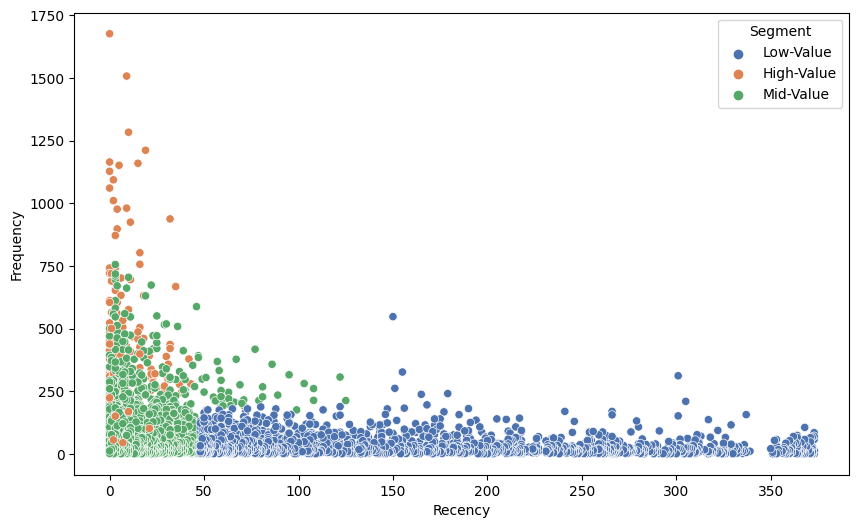

In [96]:
fig, ax = plt.subplots(figsize=(10,6))
sns.scatterplot(ax=ax,data=temp_data, x="Recency", y="Frequency",hue='Segment',palette="deep")

# ACTION REQUIRED

High Value: Improve Retention

Mid Value: Improve Retention + Increase Frequency

Low Value: Increase Frequency